# Import Statements

In [0]:
import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Download Model

Let's download the vgg model and load the parameters. We'll just be using the features portion of the model and also freezing the parameters

In [2]:
# download the model to be used
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


then, we'll check the device and move the model to the device. For this project, it is advisable to use GPU 

In [3]:
# check device available (it is advisable to use GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move model to device available
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Helper Functions

Load Image

Here's to load the image and apply transformation 

In [0]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # check size and resize if required
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    if shape is not None:
      size = shape
    
    transform = transforms.Compose([
                        transforms.Resize((size,size)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean= [0.485, 0.456, 0.406], 
                                             std = [0.229, 0.224, 0.225])
                        ])

    image = transform(image)[:3,:,:].unsqueeze(0)
    
    return image

having defined that, let's load our style and content image

In [0]:
# content image
content = load_image('https://unsplash.com/photos/fRBpWLAcWIY/download?force=true').to(device)

# style image
style = load_image('https://unsplash.com/photos/e5LdlAMpkEw/download?force=true').to(device)
# style = load_image('https://unsplash.com/photos/n-vnWQmmVoY/download?force=true').to(device)


# Convert Image

After that, we also need to un-normalize and convert our image to a numpy image so it can be displayed, hence we have another helper function

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

now let's pass display our images

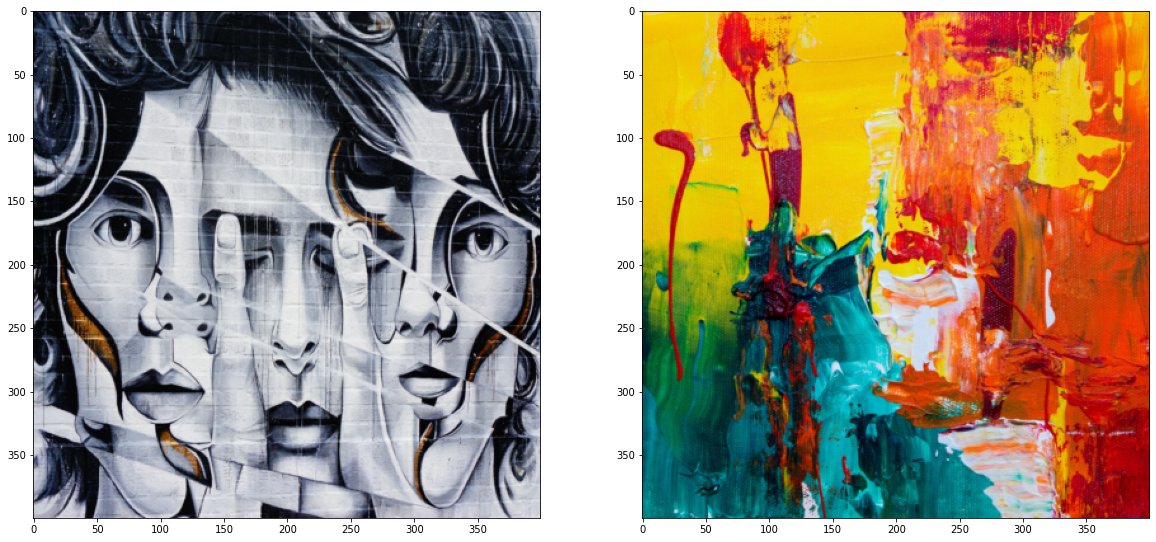

In [8]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

# Get Features

We will be needing a get_features function to capture both the style and content of the image fed into the model. This will be a generalised function as it captures the features of both the content and style image

In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

# Then finally the Gram matrix

A Gram Matrix is an important application is to compute linear independence: a set of vectors are linearly independent if and only if the Gram determinant (the determinant of the Gram matrix) is non-zero.

In [0]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

# Let's style Tranfer

Putting everything together, let's now get our image features and create our first artistic image

In [0]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

Here, we weigh the style representation at different relevant level. It's advised that the number ranges from 0 to 1. Giving earlier layers more weight, result in large style artefact of the final image and the reverse give emphasis on small features.

Thus, the visually most appealing images are usually created by matching the style representation up to the highest layers in the network

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

Since it is impossible for the image content and the style content of the respective images to be completely separated, hence the new image is not a perfect match. We therefore have loss functions to use to regulate the emphasis on either the content or the style. In the code below, we will calculate the style loss and content loss then, we will sum it up to get the total loss

Total loss:  230968560.0


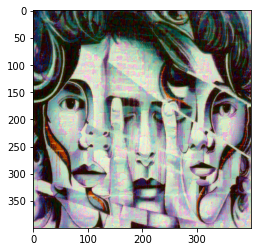

Total loss:  130430312.0


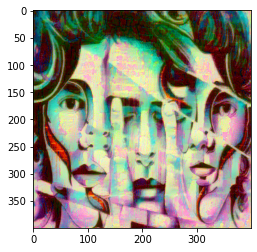

Total loss:  60330916.0


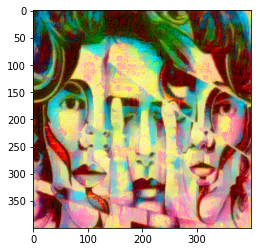

Total loss:  23477858.0


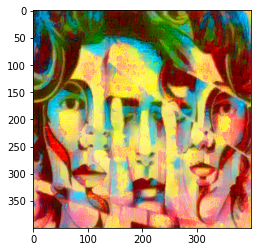

Total loss:  10935515.0


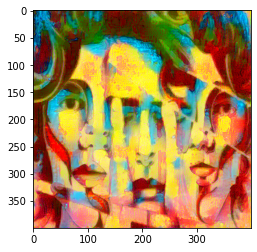

In [21]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

# Display Image

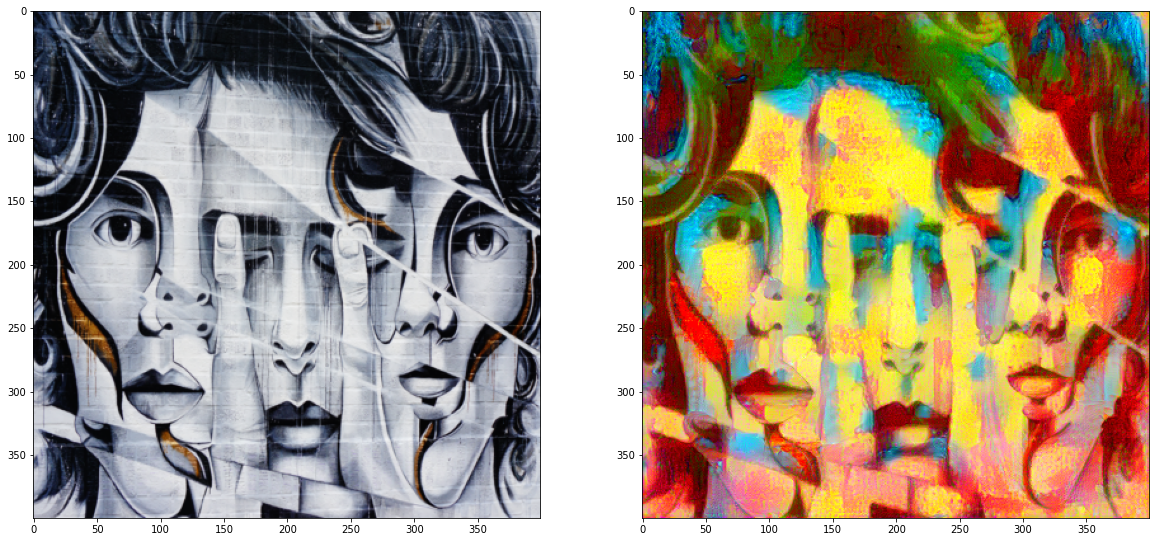

In [22]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

# Save Image

In [0]:
plt.imsave('content.jpg', im_convert(content))
plt.imsave('style.jpg', im_convert(style))
